# PrivacyNet on MNIST data.

In [1]:
import numpy as np
from keras.datasets import mnist
import random

Using TensorFlow backend.


In [2]:
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 8
plt.rcParams['figure.figsize'] = (8,8)

In [3]:
from sklearn import preprocessing
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.convolutional import UpSampling2D
from keras.layers import Conv2D, MaxPooling2D,LeakyReLU,Conv2DTranspose
from keras.layers import Input, Lambda, concatenate, Add, Concatenate
from keras import backend as K

from keras.optimizers import Adam, RMSprop

In [4]:
from privacy_net.utils.module import u_tail
from privacy_net.utils.module import y_tail
from privacy_net.utils.module import InstanceNormalization2D
from privacy_net.utils.module import residual_block
from privacy_net.models.privacy_net_model import privacyNet

/home/mx/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
def generator(img):
    #     def tileAttr(x):
    #         x = tf.expand_dims(x, axis = 1)
    #         x = tf.expand_dims(x, axis = 2)
    #         return tf.tile(x, [1, size, size, 1])

    #     y = Concatenate()([img, Lambda(tileAttr)(attr)])

    y = Conv2D(32, 5, padding="same", kernel_initializer='he_normal')(img)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(64, 3, strides=2, padding="same", kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(128, 3, strides=2, padding="same", kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)
    y = residual_block(y, 128, 3)

    y = Conv2DTranspose(64, 3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2DTranspose(32, 3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = InstanceNormalization2D()(y)
    y = Activation('relu')(y)

    y = Conv2D(1, 5, strides=1, padding='same', kernel_initializer='he_normal')(y)
    y = Activation('tanh')(y)
    return y

In [6]:
def discriminator(img, u_size, y_size, u_feat_dims=None, y_feat_dims=None, activation='tanh'):

    y = Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(img)
    y = LeakyReLU(alpha=0.2)(y)  # 14 14 32
    y = Dropout(0.25)(y)

    y = Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = ZeroPadding2D(padding=((0, 1), (0, 1)))(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 8 8 64
    y = Dropout(0.25)(y)

    y = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 128
    y = Dropout(0.25)(y)

    y = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 256
    y = Dropout(0.25)(y)

    y = Conv2D(512, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 2 2 512
    y = Dropout(0.25)(y)

    pred_f_u = []
    if not u_feat_dims:
        u_feat_dims = [2 for _ in range(u_size)]
        
    pred_f_y = []
    if not y_feat_dims:
        y_feat_dims = [2 for _ in range(y_size)]

    for i in range(u_size):
        temp_u = Conv2D(u_feat_dims[i], kernel_size=2, strides=1, kernel_initializer='he_normal',
                        activation=activation)(y)
        temp_u = Flatten()(temp_u)
        pred_f_u.append(temp_u)
        
    for i in range(y_size):
        temp_y = Conv2D(y_feat_dims[i], kernel_size=2, strides=1, kernel_initializer='he_normal',
                        activation=activation)(y)
        temp_y = Flatten()(temp_y)
        pred_f_y.append(temp_y)

    return pred_f_u,pred_f_y

In [7]:
def generatorV2(img):

    
    trans_x = Conv2D(32, kernel_size=3,
                         padding='same',
                         activation='relu')(img)
    trans_x = Conv2D(64, kernel_size=3,
                         padding='same',
                         activation='relu')(trans_x)
    trans_x = Conv2D(1, 5, strides=1, padding='same', kernel_initializer='he_normal')(trans_x)
    trans_x = Activation('tanh')(trans_x)
    return trans_x

In [8]:
def generatorV3(img):
    def mean_layer(x):
        x = tf.reduce_mean(x, axis=3)
        return tf.expand_dims(x, -1)
    trans_x = Conv2D(32, kernel_size=3,
                         padding='same',
                         activation='relu')(img)
    trans_x = Conv2D(64, kernel_size=3,
                         padding='same',
                         activation='tanh')(trans_x)
    trans_x = Lambda(mean_layer)(trans_x)
    return trans_x

In [9]:
def generatorV4(img):
    def mean_layer(x):
        x = tf.reduce_mean(x, axis=3)
        return tf.expand_dims(x, -1)
    trans_x = Conv2D(96, kernel_size=3,
                         padding='same',
                         activation='tanh')(img)
    trans_x = Lambda(mean_layer)(trans_x)
    return trans_x

In [10]:
def save_some(im_list,name):
    im_list = np.squeeze(im_list)
    num_list = len(im_list)
    plt.figure(figsize=(3 * num_list, 4))
    for i, array in enumerate(im_list):
        plt.subplot(1, len(im_list), i + 1)
        plt.imshow(((array + 1) * 127.5).astype(np.uint8), cmap='gray')
        plt.axis('off')
    plt.savefig(name)

# Reversed digits experiment

In [11]:
class reversedMNISTGenerator():
    def __init__(self, batch_size=16):

        self.input_shape = (28, 28, 1)
        self.batch_size = batch_size
        (self.x_train, self.digit_train), (self.x_test, self.digit_test) = mnist.load_data()
        self.x_train = np.expand_dims(self.x_train, axis=-1)
        self.x_test = np.expand_dims(self.x_test, axis=-1)
        
        self.x_train = np.concatenate((self.x_train,255-self.x_train),axis=0)
        self.x_test = np.concatenate((self.x_test,255-self.x_test),axis=0)
        self.digit_train = np.concatenate((self.digit_train,self.digit_train),axis=0)
        self.digit_test = np.concatenate((self.digit_test,self.digit_test),axis=0)
        
        self.train_size = self.x_train.shape[0]
        self.test_size = self.x_test.shape[0]
        
        self.u_train, self.u_test = self.load_public_label()
        self.y_train, self.y_test = self.load_sensitive_label()
        
        self.steps_per_epoch = self.default_training_steps
        self.test_steps = self.default_testing_steps

        self.cur_train_step = 0
        self.cur_test_step = 0
        self.train_ind_list = np.array([i for i in range(self.train_size)])
        self.test_ind_list = np.array([i for i in range(self.test_size)])
        random.seed(1234)
        random.shuffle(self.train_ind_list)
#         random.shuffle(self.test_ind_list)

    # property is a getter
    @property
    def default_training_steps(self):
        # make sure train with full batch size which means each epoch less than batch size images being used.
        return int(np.floor(self.train_size / self.batch_size))

    @property
    def default_testing_steps(self):
        # make sure train with full batch size which means each epoch less than batch size images being used.
        return int(np.floor(self.test_size / self.batch_size))

    def load_public_label(self):
        # prepare utility labels
#         u_train = np.zeros_like(self.digit_train)
#         u_test = np.zeros_like(self.digit_test)

#         u_train[self.digit_train % 2 == 1] = 1
#         u_test[self.digit_test % 2 == 1] = 1

        return self.digit_train, self.digit_test

    def load_sensitive_label(self):
        # prepare privacy labels
        y_train = np.zeros_like(self.digit_train)
        y_test = np.zeros_like(self.digit_test)
        
        y_train[int(self.train_size/2):] = 1
        y_test[int(self.test_size/2):] = 1
        return y_train, y_test

    def nextTrain(self):
        while True:

            # set self.cur_train_ind
            # cur_train_ind has indices of batch_sizes, this indices correpond to the image ids
            self.fetchCurrentTrainInd()
            train_x = self.x_train[self.cur_train_ind]
            train_x = train_x / 127.5 - 1

            train_u = np.zeros((self.batch_size, 10))
            for i in range(self.batch_size):
                train_u[i][self.u_train[self.cur_train_ind[i]]] = 1
            train_y = np.zeros((self.batch_size, 2))
            for i in range(self.batch_size):
                train_y[i][self.y_train[self.cur_train_ind[i]]] = 1

            inputs = {'input_x': train_x, 'input_y': [train_y], 'input_u': [train_u]}
            output = np.zeros((self.batch_size, 1))
            self.cur_train_step += 1
            yield inputs, output

    def fetchCurrentTrainInd(self):
        # this function find cur_train_ind for each step
        # it read batch_size's image_ids, starting from cur_train_step(batch_size,augment_ratio)

        # if self.cur_train_step%self.augment_ratio != 0:
        #     return

        # when epoch end it will shuffle image_ids and reset cur_train_step, namely, read from the start
        if self.cur_train_step >= self.steps_per_epoch:
            random.shuffle(self.train_ind_list)
            # print("shuffling")
            self.cur_train_step = 0

        cur_train_start = int(self.cur_train_step) * self.batch_size
        cur_train_end = cur_train_start + self.batch_size
        if cur_train_end > self.train_size:
            cur_train_end = self.train_size
        self.cur_train_ind = self.train_ind_list[np.arange(cur_train_start, cur_train_end).astype(int)]

    def nextVal(self):
        while True:
            if self.cur_test_step == self.test_steps:
                self.cur_test_step = 0
                random.shuffle(self.test_ind_list)
            cur_test_start = int(self.cur_test_step) * self.batch_size
            cur_test_end = cur_test_start + self.batch_size
            if cur_test_end > self.test_size:
                cur_test_end = self.test_size
            self.cur_test_ind = self.test_ind_list[np.arange(cur_test_start, cur_test_end)]

            test_x = self.x_test[self.cur_test_ind]
            test_x = test_x / 127.5 - 1

            test_u = np.zeros((self.batch_size, 10))
            for i in range(self.batch_size):
                test_u[i][self.u_test[self.cur_test_ind[i]]] = 1
            test_y = np.zeros((self.batch_size, 2))
            for i in range(self.batch_size):
                test_y[i][self.y_test[self.cur_test_ind[i]]] = 1

            self.cur_test_step += 1
            inputs = {'input_x': test_x, 'input_y': [test_y], 'input_u': [test_u]}
            output = np.zeros((self.batch_size, 1))
            yield inputs, output

In [12]:
class privacyNetV4(privacyNet):

    def __init__(self, u_input_dims=[2, 2, 2, 2], y_input_dims=[2], u_feat_dims=[2, 2, 2, 2], y_feat_dims=[2],mode=0,
                 **kwargs):
        self.u_input_dims = u_input_dims
        self.y_input_dims = y_input_dims
        self.u_feat_dims = u_feat_dims
        self.y_feat_dims = y_feat_dims
        self.mode = mode # 0->generatorV2 1->generatorV3 2->generatorV4
        super(privacyNetV4, self).__init__(**kwargs)

    def build_model(self):

        """Build Discriminator and Generator and Transformer, seperately.
        This method requires no inputs and returns nothing.
        self.d_model, self.g_model, self.transform_tail_models are goals for this method.
        NOTE: The following 'Output's and 'Input's are used for introducing model specs.

        # D model arguments:
            - d_model: Discriminator part.
        Input:
            - attr_y_input: list of Input Tensors. sensitive labels, Y.
            - attr_u_input(Optional): list, of Input Tensors. public labels, U.
            - img_input: Input Tensor, shared with g_model. raw images, X.
        Output:
            - loss_y_output: list, H-score between imgs and sensitive labels. H_score.
            - loss_u_output: list, H-score between imgs and public labels. Might be None. H_score
            - pred_real: predictions of real images. prob.
            - pred_f_y: list,feature of Y. y(X).
            - pred_f_u: list,feature of U. u(X).

        # G model:
            - g_model: Generator part.
        Input:
            - img_input: Input Tensor, shared with d_model. raw images, X.
        Output:
            - img_output: transformed images. transformed images, Z.

        # T models:
            - transform_tail_models: list of T models.
        Input:
            - transform_y_input: list of input of third networks in order to filter
                                 sensitive information. y(Z)
        Output:
            - transform_y_tail: list. h(y(Z))

        """
        ################## Part I ######################
        ## start building D model
        self.img_input = Input(self.image_size)
        self.attr_y_input = []  # placeholder for every sensitive labels
        self.attr_u_input = []  # placeholder for every public labels

        for i in range(self.y_size):
            self.attr_y_input.append(Input((self.y_input_dims[i],)))
        for j in range(self.u_size):
            self.attr_u_input.append(Input((self.u_input_dims[j],)))

        self.pred_f_u, _ = discriminator(self.img_input,
                                                     self.u_size,
                                                     0,
                                                     self.u_feat_dims,
                                                     activation=self.activation)
        _, self.pred_f_y = discriminator(self.img_input,
                                                     0,
                                                     self.y_size,
                                                     self.y_feat_dims,
                                                     activation=self.activation)
        # All tail networks are separated
        self.attr_y_tail = []  # holding tails network for sensitive_attrs
        self.attr_u_tail = []  # holding tails network for public_attrs

        for i in range(self.y_size):
            self.attr_y_tail.append(y_tail(self.attr_y_input[i],
                                           self.y_feat_dims[i],
                                           activation=self.activation))

        for j in range(self.u_size):
            self.attr_u_tail.append(u_tail(self.attr_u_input[j],
                                           self.u_feat_dims[j],
                                           activation=self.activation))

        self.loss_y_output = []  # containing sensitive H-score
        self.loss_u_output = []  # containing public H-score

        for i in range(self.y_size):
            self.loss_y_output.append(Lambda(self.neg_hscore)([self.pred_f_y[i], self.attr_y_tail[i]]))

        for j in range(self.u_size):
            self.loss_u_output.append(Lambda(self.neg_hscore)([self.pred_f_u[j], self.attr_u_tail[j]]))

        self.d_model = Model(inputs=[self.img_input] + self.attr_u_input + self.attr_y_input,
                             outputs= self.loss_u_output + self.loss_y_output
                                     + self.pred_f_u + self.pred_f_y)
        if self.d_model_dir:
            self.d_model.load_weights(self.d_model_dir)  # load pretrained model if avialable
        ## end building D model
        self.d_model.summary()

        ################## Part II ######################
        ## start building G model
        if self.mode == 0:
            self.img_output = generatorV2(self.img_input)  # pass image into generator
        elif self.mode == 1:
            self.img_output = generatorV3(self.img_input)  # pass image into generator
        elif self.mode == 2:
            self.img_output = generatorV4(self.img_input)  # pass image into generator
        else:
            self.img_output = generator(self.img_input)  # pass image into generator
            
        self.g_model = Model(inputs=[self.img_input], outputs=[self.img_output])

        if self.g_model_dir:
            self.g_model.load_weights(self.g_model_dir)  # load pretrained model if avialable
        ## end building G model
        self.g_model.summary()


    def build_loss(self):
        """Build Discriminator and Generator and Transformer loss, itegrating G,D,T into privacy_net model.
        This project uses three steps training, D->T->G. Thus, three losses are introduced accordingly.

        # Network Arguments:

            - img_a: Input Tensor. Raw images.
            - attr_y: list, Input Tensors. Sensitive labels.
            - attr_u: list, Input Tensors. Public labels.
            - img_a_trans: Output Tensor of G. Transformed images.
            - pred_real(local): List, Output tensor of D. On raw images.
            Details: pred_real
            |0       |1:1+u_size   |1+u_size:1+u_size+y_size|1+u_size+y_size:1+u_size*2+y_size|1+u_size*2+y_size:1+u_size*2+y_size*2|
            |pred_dis|loss_u_hscore|      loss_y_hscore     |           u(X)                  |               y(X)                  |
            - pred_trans(local): List, Output tensor of D. On transformed images.
            Details: pred_trans
            |0       |1:1+u_size   |1+u_size:1+u_size+y_size|1+u_size+y_size:1+u_size*2+y_size|1+u_size*2+y_size:1+u_size*2+y_size*2|
            |pred_dis|loss_u_hscore|      loss_y_hscore     |           u(Z)                  |               y(Z)                  |
            - h_z(local): list, Output Tensors of T. h(y(Z)).
        """

        # Same implementation with neg_hscore, in case of mixing up with Lambda layer.
        def neg_hscore_loss(x):
            """
            neg hscore loss implementation
            """
            f = x[0]
            g = x[1]
            f0 = f - K.mean(f, axis=0)
            g0 = g - K.mean(g, axis=0)
            corr = tf.reduce_mean(tf.reduce_sum(tf.multiply(f0, g0), 1))
            cov_f = K.dot(K.transpose(f0), f0) / K.cast(K.shape(f0)[0] - 1, dtype='float32')
            cov_g = K.dot(K.transpose(g0), g0) / K.cast(K.shape(g0)[0] - 1, dtype='float32')
            return - corr + tf.trace(K.dot(cov_f, cov_g)) / 2

        ########### Part 0 ################
        ## Connecting three models
        self.img_a = Input(shape=self.image_size)  # Raw images tensor.

        self.attr_y = []  # sensitive_label tensor.
        self.attr_u = []  # public_label tensor.
        for i in range(self.y_size):
            self.attr_y.append(Input((self.y_input_dims[i],)))
        for j in range(self.u_size):
            self.attr_u.append(Input((self.u_input_dims[j],)))

        self.img_a_trans = self.g_model(self.img_a)  # Transformed image Tensor.
        pred_trans = self.d_model([self.img_a_trans] + self.attr_u + self.attr_y)  # D output tensor.

        ## end Connecting three models

        ############## Part I #################
        ## build D loss
        # compute u_loss in total
        for i in range(self.u_size):
            if i == 0:
                d_loss_u_total = pred_trans[i]
            else:
                d_loss_u_total += pred_trans[i]

        # compute y_loss in total
        for j in range(self.u_size, self.u_size + self.y_size):
            if j == self.u_size:
                d_loss_y_total = pred_trans[j]
            else:
                d_loss_y_total += pred_trans[j]

        # d_loss = u_loss+y_loss+loss_real+loss_fake+loss_gp
        if self.u_size == 0:
            self.d_loss = (1. / self.y_size) * self.gamma * d_loss_y_total
        else:
            self.d_loss = (1 / self.u_size) * d_loss_u_total + (1. / self.y_size) * self.gamma * d_loss_y_total
        ## end build D loss

        ############## Part II #################
        ## build G

        g_loss_y_total = d_loss_y_total
        g_loss_u_total = d_loss_u_total
        
        if self.u_size == 0:
            self.g_loss = - (1. / self.y_size) * self.gamma * g_loss_y_total
        else:
            self.g_loss = (1. / self.u_size) * g_loss_u_total - (1. / self.y_size) * self.gamma * g_loss_y_total
        ## end build G loss


        # save list for detail printing.
        self.d_loss_list_print = []
        if self.u_size > 0:
            self.d_loss_list_print.append(d_loss_u_total)
        self.d_loss_list_print.append(d_loss_y_total)

        self.g_loss_list_print = []
        if self.u_size > 0:
            self.g_loss_list_print.append(g_loss_u_total)
        self.g_loss_list_print.append(g_loss_y_total)

    def build_optimizer(self):

        self.g_training_updates = Adam(lr=self.lr, decay=5e-9, beta_1=self.b1, beta_2=self.b2).get_updates(
            self.g_model.trainable_weights, [], self.g_loss)
        self.g_train = K.function([self.img_a] + self.attr_u + self.attr_y, self.g_loss_list_print, self.g_training_updates)


        self.d_training_updates = Adam(lr=self.lr, decay=5e-9, beta_1=self.b1, beta_2=self.b2).get_updates(
            self.d_model.trainable_weights, [], self.d_loss)
        self.d_train = K.function([self.img_a] + self.attr_u + self.attr_y, self.d_loss_list_print,
                                  self.d_training_updates)
    def build_output(self):
        pass
    
    def train(self):
        dict_val, _ = next(self.celeba_generator.nextVal())
        sample_input_x = dict_val['input_x']
        save_some(sample_input_x[:10], os.path.join(self.log_dir, 'original_image'))
        loss_g = []
        loss_d = []
        for j in range(self.start_epoch, self.num_epochs):
            # clean up loss logs on epoch begin, loss list different when u_size = 0
            for i in range(self.celeba_generator.steps_per_epoch):
                dict_input, output = next(self.celeba_generator.nextTrain())
#                 output = output.reshape(self.batch_size)
                input_x = dict_input['input_x']
                input_y = dict_input['input_y']
                input_u = dict_input['input_u']
                input_y_batch = []
                input_u_batch = []
                for ind_1 in range(self.y_size):
                    input_y_batch.append(input_y[ind_1])
                for ind_2 in range(self.u_size):
                    input_u_batch.append(input_u[ind_2])
                for _ in range(self.d_ites):
                    errD = self.d_train([input_x] + input_u_batch + input_y_batch)
                errT = []
                for _ in range(self.g_ites):
                    errG = self.g_train([input_x] + input_u_batch + input_y_batch)

                if i % 100 == 0:
                    if self.u_size > 0:
                        print(
                            'epoch{}/{},batch:{}/{},loss_u D:{},loss_y D:{},loss_u G:{},loss_y G:{}'.
                                format(j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                       np.mean(errD[0]), np.mean(errD[1]), np.mean(errG[0]), np.mean(errG[1])))
                    else:
                        print(
                            'epoch{}/{},batch:{}/{},loss_y D:{},loss_y G:{}'.
                                format(j, self.num_epochs, i, self.celeba_generator.steps_per_epoch,
                                       np.mean(errD[0]), np.mean(errG[0]),
                                       ))

                    loss_d.append(np.mean(errD[0]))
#                     for ind_1 in range(len(d_loss_list)):
#                         loss_d[ind_1 + 1].append(np.mean(d_loss_list[ind_1]))

                    loss_g.append(np.mean(errD[1]))
#                     for ind_2 in range(len(g_loss_list)):
#                         loss_g[ind_2 + 1].append(np.mean(g_loss_list[ind_2]))

#                     loss_t.append(np.mean(errT))

                if i % 1000 == 0:
                    val_trans_x = self.g_model.predict(sample_input_x)
                    save_some(val_trans_x[:10], os.path.join(self.log_dir, 'predict_' + str(j) + '_' + str(i)))

            if (j+1) % 5 == 0:
                self.g_model.save_weights(os.path.join(self.log_dir, 'g_model_' + self.date + '_' + str(j) + '.h5'))
                self.d_model.save_weights(os.path.join(self.log_dir, 'd_model_' + self.date + '_' + str(j) + '.h5'))
        results_loss = {}
        results_loss['loss_u'] = loss_d
        results_loss['loss_y'] = loss_g
        np.save(os.path.join(self.log_dir, 'result_loss_' + self.date + '_' + str(j) + '.npy'), results_loss)



In [13]:
import os
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
batch_size = 16
K.set_learning_phase(False)
set_session(tf.Session())

In [14]:
for gamma in [1,10]:
    for ind_mode in [3]:
        log_dir = 'logs_mnist_mode_'+str(ind_mode)+'_gamma_'+str(gamma)
        if not os.path.exists(log_dir):
            os.makedirs(log_dir)
        mnist_generator = reversedMNISTGenerator()
        privacy_net = privacyNetV4(log_dir=log_dir,
                                   g_model_dir=None,
                                   d_model_dir=None,
                                   start_epoch=0,
                                   batch_size=batch_size,
                                   image_size=(28, 28, 1),
                                   data_generator = mnist_generator,
                                   u_input_dims=[10],
                                   u_feat_dims=[10],
                                   y_feat_dims=[2],
                                   u_size = 1,
                                   mode=ind_mode,
                                   epochs=10, lambda_cls=1,
                                   gamma=gamma, activation='tanh',t_ites =1)
        privacy_net.train()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 14, 14, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_l

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 28, 28, 32)   832         input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization2d_1 (Ins (None, 28, 28, 32)   64          conv2d_13[0][0]                  
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 28, 28, 32)   0           instance_normalization2d_1[0][0] 
__________________________________________________________________________________________________
conv2d_14 

epoch0/10,batch:0/7500,loss_u D:0.03723115101456642,loss_y D:-0.004124910570681095,loss_u G:0.009910369291901588,loss_y G:-0.016225365921854973
epoch0/10,batch:100/7500,loss_u D:-0.2779220640659332,loss_y D:-0.025592030957341194,loss_u G:-0.301277220249176,loss_y G:-0.03580569475889206
epoch0/10,batch:200/7500,loss_u D:-0.6266646385192871,loss_y D:-0.02111377753317356,loss_u G:-0.6474144458770752,loss_y G:-0.028757484629750252
epoch0/10,batch:300/7500,loss_u D:-0.9830014109611511,loss_y D:0.0073172831907868385,loss_u G:-0.9989206790924072,loss_y G:0.00016091635916382074
epoch0/10,batch:400/7500,loss_u D:-1.1637358665466309,loss_y D:-0.012538328766822815,loss_u G:-1.1775788068771362,loss_y G:-0.016419023275375366
epoch0/10,batch:500/7500,loss_u D:-1.2996612787246704,loss_y D:-0.011597833596169949,loss_u G:-1.3154900074005127,loss_y G:-0.012863557785749435
epoch0/10,batch:600/7500,loss_u D:-1.377617597579956,loss_y D:-0.01687401719391346,loss_u G:-1.4136148691177368,loss_y G:-0.018694970

epoch0/10,batch:5600/7500,loss_u D:-1.9105830192565918,loss_y D:-0.007466122042387724,loss_u G:-1.914428472518921,loss_y G:-0.0119715491309762
epoch0/10,batch:5700/7500,loss_u D:-1.6173397302627563,loss_y D:-0.020956793799996376,loss_u G:-1.618385910987854,loss_y G:-0.0388619527220726
epoch0/10,batch:5800/7500,loss_u D:-1.6570544242858887,loss_y D:0.023462004959583282,loss_u G:-1.664964199066162,loss_y G:0.01172227505594492
epoch0/10,batch:5900/7500,loss_u D:-1.813349723815918,loss_y D:-0.0047304267063736916,loss_u G:-1.8145573139190674,loss_y G:-0.01370198093354702
epoch0/10,batch:6000/7500,loss_u D:-1.765334963798523,loss_y D:-0.02116372436285019,loss_u G:-1.7810328006744385,loss_y G:-0.026072770357131958
epoch0/10,batch:6100/7500,loss_u D:-2.053975820541382,loss_y D:-0.02005193382501602,loss_u G:-2.0565574169158936,loss_y G:-0.03255411237478256
epoch0/10,batch:6200/7500,loss_u D:-1.8487844467163086,loss_y D:-0.004723364487290382,loss_u G:-1.8853667974472046,loss_y G:-0.0074521331116

epoch1/10,batch:3800/7500,loss_u D:-2.009077787399292,loss_y D:-0.007485116831958294,loss_u G:-2.0111539363861084,loss_y G:-0.012842575088143349
epoch1/10,batch:3900/7500,loss_u D:-1.8687297105789185,loss_y D:-0.014281781390309334,loss_u G:-1.8705488443374634,loss_y G:-0.025950711220502853
epoch1/10,batch:4000/7500,loss_u D:-2.1678378582000732,loss_y D:-0.01228531263768673,loss_u G:-2.1679868698120117,loss_y G:-0.014964447356760502
epoch1/10,batch:4100/7500,loss_u D:-1.8811951875686646,loss_y D:0.001060735434293747,loss_u G:-1.8899692296981812,loss_y G:-6.936414865776896e-05
epoch1/10,batch:4200/7500,loss_u D:-1.921447992324829,loss_y D:-0.004209529142826796,loss_u G:-1.9335181713104248,loss_y G:-0.007204031106084585
epoch1/10,batch:4300/7500,loss_u D:-1.7515597343444824,loss_y D:0.00776180624961853,loss_u G:-1.7980977296829224,loss_y G:0.0039903391152620316
epoch1/10,batch:4400/7500,loss_u D:-1.9658478498458862,loss_y D:-0.004903066903352737,loss_u G:-1.9668779373168945,loss_y G:-0.00

epoch2/10,batch:2000/7500,loss_u D:-2.3334405422210693,loss_y D:-0.0008820584043860435,loss_u G:-2.3396143913269043,loss_y G:-0.002076697302982211
epoch2/10,batch:2100/7500,loss_u D:-2.203982353210449,loss_y D:-0.004859241656959057,loss_u G:-2.2430176734924316,loss_y G:-0.0065005384385585785
epoch2/10,batch:2200/7500,loss_u D:-1.5031540393829346,loss_y D:0.0030572540126740932,loss_u G:-1.5237970352172852,loss_y G:-0.0016666215378791094
epoch2/10,batch:2300/7500,loss_u D:-2.0979762077331543,loss_y D:-0.012121886014938354,loss_u G:-2.1012179851531982,loss_y G:-0.02374998852610588
epoch2/10,batch:2400/7500,loss_u D:-2.358785390853882,loss_y D:0.003993714228272438,loss_u G:-2.3654186725616455,loss_y G:0.001344611868262291
epoch2/10,batch:2500/7500,loss_u D:-2.1079654693603516,loss_y D:0.006252834107726812,loss_u G:-2.1156744956970215,loss_y G:-0.002408115193247795
epoch2/10,batch:2600/7500,loss_u D:-2.5368800163269043,loss_y D:0.0027201471384614706,loss_u G:-2.5418434143066406,loss_y G:0.0

/home/mx/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


epoch2/10,batch:3100/7500,loss_u D:-1.9800426959991455,loss_y D:0.004351537674665451,loss_u G:-1.9846224784851074,loss_y G:-0.0009162860224023461
epoch2/10,batch:3200/7500,loss_u D:-2.030283212661743,loss_y D:-0.002430447842925787,loss_u G:-2.0553882122039795,loss_y G:-0.0043818107806146145
epoch2/10,batch:3300/7500,loss_u D:-2.3167996406555176,loss_y D:-0.004526077304035425,loss_u G:-2.331714153289795,loss_y G:-0.018094675615429878
epoch2/10,batch:3400/7500,loss_u D:-2.28950834274292,loss_y D:0.024415504187345505,loss_u G:-2.2926807403564453,loss_y G:0.017721962183713913
epoch2/10,batch:3500/7500,loss_u D:-2.3479020595550537,loss_y D:0.004503671079874039,loss_u G:-2.364712953567505,loss_y G:0.003641056129708886
epoch2/10,batch:3600/7500,loss_u D:-2.2894530296325684,loss_y D:-0.0011630862718448043,loss_u G:-2.2993972301483154,loss_y G:-0.001260781311430037
epoch2/10,batch:3700/7500,loss_u D:-2.4106903076171875,loss_y D:0.000527435215190053,loss_u G:-2.4120447635650635,loss_y G:0.000388

epoch3/10,batch:1300/7500,loss_u D:-2.6464033126831055,loss_y D:-0.000625981017947197,loss_u G:-2.6506805419921875,loss_y G:-0.007470160722732544
epoch3/10,batch:1400/7500,loss_u D:-1.700148582458496,loss_y D:0.005338101182132959,loss_u G:-1.7190524339675903,loss_y G:0.0028678609523922205
epoch3/10,batch:1500/7500,loss_u D:-2.1342570781707764,loss_y D:-0.007117850240319967,loss_u G:-2.1751296520233154,loss_y G:-0.010227960534393787
epoch3/10,batch:1600/7500,loss_u D:-2.2711477279663086,loss_y D:0.01968749798834324,loss_u G:-2.272589683532715,loss_y G:-0.01096454355865717
epoch3/10,batch:1700/7500,loss_u D:-2.8145816326141357,loss_y D:0.0017861677333712578,loss_u G:-2.822725772857666,loss_y G:-0.0019343523308634758
epoch3/10,batch:1800/7500,loss_u D:-2.7012176513671875,loss_y D:-0.0029969499446451664,loss_u G:-2.7020065784454346,loss_y G:-0.007491323631256819
epoch3/10,batch:1900/7500,loss_u D:-2.623854160308838,loss_y D:0.0060019101947546005,loss_u G:-2.6300973892211914,loss_y G:0.0050

epoch3/10,batch:7000/7500,loss_u D:-2.16748309135437,loss_y D:-0.006120903417468071,loss_u G:-2.172893762588501,loss_y G:-0.009991916827857494
epoch3/10,batch:7100/7500,loss_u D:-2.5153584480285645,loss_y D:0.010631120763719082,loss_u G:-2.521345615386963,loss_y G:0.006301091518253088
epoch3/10,batch:7200/7500,loss_u D:-2.5551185607910156,loss_y D:-0.020385829731822014,loss_u G:-2.5585713386535645,loss_y G:-0.025928741320967674
epoch3/10,batch:7300/7500,loss_u D:-2.387803316116333,loss_y D:0.0033468673937022686,loss_u G:-2.395214557647705,loss_y G:-0.008780847303569317
epoch3/10,batch:7400/7500,loss_u D:-1.907188892364502,loss_y D:0.011283460073173046,loss_u G:-1.922147512435913,loss_y G:0.008499754592776299
epoch4/10,batch:0/7500,loss_u D:-1.6496891975402832,loss_y D:-0.00920051895081997,loss_u G:-1.685942530632019,loss_y G:-0.011227023787796497
epoch4/10,batch:100/7500,loss_u D:-2.24035382270813,loss_y D:-0.022655121982097626,loss_u G:-2.252807378768921,loss_y G:-0.029750468209385872

epoch4/10,batch:5200/7500,loss_u D:-2.65852689743042,loss_y D:7.545863354607718e-06,loss_u G:-2.6656839847564697,loss_y G:7.503172582801199e-06
epoch4/10,batch:5300/7500,loss_u D:-2.1055400371551514,loss_y D:-2.5663697670097463e-05,loss_u G:-2.1265547275543213,loss_y G:-2.573159508756362e-05
epoch4/10,batch:5400/7500,loss_u D:-2.5929982662200928,loss_y D:1.0061326065624598e-05,loss_u G:-2.602383852005005,loss_y G:1.000398970063543e-05
epoch4/10,batch:5500/7500,loss_u D:-2.449723720550537,loss_y D:-5.898829840589315e-06,loss_u G:-2.4547464847564697,loss_y G:-5.902738848817535e-06
epoch4/10,batch:5600/7500,loss_u D:-2.183598518371582,loss_y D:-8.005876225070097e-06,loss_u G:-2.190126895904541,loss_y G:-8.05150375526864e-06
epoch4/10,batch:5700/7500,loss_u D:-1.9981653690338135,loss_y D:-9.2613061042357e-07,loss_u G:-2.014307975769043,loss_y G:-9.554324833516148e-07
epoch4/10,batch:5800/7500,loss_u D:-2.580083131790161,loss_y D:1.0984638720401563e-05,loss_u G:-2.5820860862731934,loss_y G:

epoch5/10,batch:3400/7500,loss_u D:-2.6450185775756836,loss_y D:-0.011485578492283821,loss_u G:-2.647203207015991,loss_y G:-0.017712345346808434
epoch5/10,batch:3500/7500,loss_u D:-2.884737014770508,loss_y D:-0.0008684556814841926,loss_u G:-2.885590076446533,loss_y G:-0.0021076954435557127
epoch5/10,batch:3600/7500,loss_u D:-1.941523790359497,loss_y D:0.00010343689064029604,loss_u G:-1.960433006286621,loss_y G:-1.9145010810461827e-05
epoch5/10,batch:3700/7500,loss_u D:-2.3346009254455566,loss_y D:-0.0007457519532181323,loss_u G:-2.3388614654541016,loss_y G:-0.0007675854139961302
epoch5/10,batch:3800/7500,loss_u D:-2.5284886360168457,loss_y D:0.0009448962518945336,loss_u G:-2.5329155921936035,loss_y G:0.0008645913330838084
epoch5/10,batch:3900/7500,loss_u D:-2.2282228469848633,loss_y D:0.0008262065821327269,loss_u G:-2.2339279651641846,loss_y G:0.0007111976156011224
epoch5/10,batch:4000/7500,loss_u D:-2.6284217834472656,loss_y D:-0.005813803989440203,loss_u G:-2.6502153873443604,loss_y 

epoch6/10,batch:1600/7500,loss_u D:-2.1241891384124756,loss_y D:0.00030597997829318047,loss_u G:-2.128970146179199,loss_y G:0.00029893717146478593
epoch6/10,batch:1700/7500,loss_u D:-2.510650873184204,loss_y D:0.0001291352091357112,loss_u G:-2.5142455101013184,loss_y G:0.0001254369126399979
epoch6/10,batch:1800/7500,loss_u D:-2.6388962268829346,loss_y D:-0.00014920094690751284,loss_u G:-2.6427910327911377,loss_y G:-0.0001511983573436737
epoch6/10,batch:1900/7500,loss_u D:-2.4709973335266113,loss_y D:0.00028910761466249824,loss_u G:-2.474159002304077,loss_y G:0.00028154393658041954
epoch6/10,batch:2000/7500,loss_u D:-2.557600259780884,loss_y D:-0.00011581076250877231,loss_u G:-2.559541702270508,loss_y G:-0.00012236105976626277
epoch6/10,batch:2100/7500,loss_u D:-2.2632527351379395,loss_y D:0.0008205539197660983,loss_u G:-2.2868313789367676,loss_y G:0.0006560866604559124
epoch6/10,batch:2200/7500,loss_u D:-2.103684902191162,loss_y D:-0.0009360131225548685,loss_u G:-2.1088459491729736,los

epoch6/10,batch:7300/7500,loss_u D:-2.3759453296661377,loss_y D:5.932964268140495e-05,loss_u G:-2.3791322708129883,loss_y G:5.6875953305279836e-05
epoch6/10,batch:7400/7500,loss_u D:-2.958564281463623,loss_y D:0.00032194689265452325,loss_u G:-2.95914363861084,loss_y G:0.0003111795231234282
epoch7/10,batch:0/7500,loss_u D:-2.3645477294921875,loss_y D:5.052935375715606e-05,loss_u G:-2.367366313934326,loss_y G:4.747565253637731e-05
epoch7/10,batch:100/7500,loss_u D:-2.95870304107666,loss_y D:2.861525172193069e-05,loss_u G:-2.9590792655944824,loss_y G:2.7078705898020416e-05
epoch7/10,batch:200/7500,loss_u D:-2.493000030517578,loss_y D:-0.00018682083464227617,loss_u G:-2.5032870769500732,loss_y G:-0.00019534482271410525
epoch7/10,batch:300/7500,loss_u D:-2.704984426498413,loss_y D:0.00011704923235811293,loss_u G:-2.7062220573425293,loss_y G:0.00011499573156470433
epoch7/10,batch:400/7500,loss_u D:-2.5959277153015137,loss_y D:-0.000417326606111601,loss_u G:-2.5979185104370117,loss_y G:-0.000

epoch7/10,batch:5500/7500,loss_u D:-2.6869821548461914,loss_y D:9.960795068764128e-07,loss_u G:-2.689177989959717,loss_y G:9.96031189970381e-07
epoch7/10,batch:5600/7500,loss_u D:-2.596100330352783,loss_y D:8.537186886314885e-07,loss_u G:-2.5987348556518555,loss_y G:8.426694648733246e-07
epoch7/10,batch:5700/7500,loss_u D:-2.5733048915863037,loss_y D:-1.5244539781633648e-06,loss_u G:-2.575002908706665,loss_y G:-1.526786604699737e-06
epoch7/10,batch:5800/7500,loss_u D:-2.31060791015625,loss_y D:-4.6295286892927834e-07,loss_u G:-2.3144078254699707,loss_y G:-4.7005968895064143e-07
epoch7/10,batch:5900/7500,loss_u D:-2.7417662143707275,loss_y D:4.549644472717773e-06,loss_u G:-2.743485927581787,loss_y G:4.532467301032739e-06
epoch7/10,batch:6000/7500,loss_u D:-2.9845876693725586,loss_y D:1.802596784727939e-06,loss_u G:-2.985523223876953,loss_y G:1.8080708059642348e-06
epoch7/10,batch:6100/7500,loss_u D:-3.1360912322998047,loss_y D:-4.2104048247892933e-07,loss_u G:-3.1380391120910645,loss_y 

epoch8/10,batch:3600/7500,loss_u D:-2.692309856414795,loss_y D:-0.00018104388436768204,loss_u G:-2.6954193115234375,loss_y G:-0.00018431912758387625
epoch8/10,batch:3700/7500,loss_u D:-2.887928009033203,loss_y D:0.0002628053480293602,loss_u G:-2.8887338638305664,loss_y G:0.00025482705677859485
epoch8/10,batch:3800/7500,loss_u D:-2.137779474258423,loss_y D:-9.757994121173397e-06,loss_u G:-2.1448678970336914,loss_y G:-9.759229214978404e-06
epoch8/10,batch:3900/7500,loss_u D:-2.614581346511841,loss_y D:4.4109772716183215e-05,loss_u G:-2.6188607215881348,loss_y G:4.379218444228172e-05
epoch8/10,batch:4000/7500,loss_u D:-2.9034042358398438,loss_y D:3.656858825706877e-05,loss_u G:-2.904517889022827,loss_y G:3.6350222217151895e-05
epoch8/10,batch:4100/7500,loss_u D:-3.28129506111145,loss_y D:1.3301651961228345e-05,loss_u G:-3.282296895980835,loss_y G:1.3312091141415294e-05
epoch8/10,batch:4200/7500,loss_u D:-2.6723108291625977,loss_y D:1.5918911230983213e-05,loss_u G:-2.6766915321350098,loss_

epoch9/10,batch:1700/7500,loss_u D:-2.602726697921753,loss_y D:-8.842268357511784e-07,loss_u G:-2.6044280529022217,loss_y G:-8.869953944667941e-07
epoch9/10,batch:1800/7500,loss_u D:-2.4079387187957764,loss_y D:-2.6807603603629104e-07,loss_u G:-2.412543773651123,loss_y G:-2.720749989748583e-07
epoch9/10,batch:1900/7500,loss_u D:-2.406751871109009,loss_y D:-4.821235393137613e-07,loss_u G:-2.417879581451416,loss_y G:-4.82892630770948e-07
epoch9/10,batch:2000/7500,loss_u D:-2.661015748977661,loss_y D:-1.2986724584607146e-07,loss_u G:-2.664821147918701,loss_y G:-1.2955966610661562e-07
epoch9/10,batch:2100/7500,loss_u D:-2.586818218231201,loss_y D:-4.2583920389915875e-08,loss_u G:-2.592846632003784,loss_y G:-4.135347353440011e-08
epoch9/10,batch:2200/7500,loss_u D:-2.600280284881592,loss_y D:-1.8179366634285543e-07,loss_u G:-2.603759288787842,loss_y G:-1.848697905870722e-07
epoch9/10,batch:2300/7500,loss_u D:-2.8776044845581055,loss_y D:-1.148223987001984e-06,loss_u G:-2.881389617919922,los

epoch9/10,batch:7300/7500,loss_u D:-2.882575750350952,loss_y D:1.6602260075160302e-05,loss_u G:-2.884964942932129,loss_y G:1.603077180334367e-05
epoch9/10,batch:7400/7500,loss_u D:-2.9103541374206543,loss_y D:9.551201947033405e-05,loss_u G:-2.9113833904266357,loss_y G:9.417092951480299e-05
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 14, 14, 32)   320         input_7[0][0]                    
________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 28, 28, 32)   832         input_7[0][0]                    
__________________________________________________________________________________________________
instance_normalization2d_14 (In (None, 28, 28, 32)   64          conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 28, 28, 32)   0           instance_normalization2d_14[0][0]
__________________________________________________________________________________________________
conv2d_38 

epoch0/10,batch:0/7500,loss_u D:0.00952184572815895,loss_y D:0.015028671361505985,loss_u G:-0.017908016219735146,loss_y G:-0.0012424634769558907
epoch0/10,batch:100/7500,loss_u D:-0.1246500313282013,loss_y D:0.027843456715345383,loss_u G:-0.14446641504764557,loss_y G:0.014286740683019161
epoch0/10,batch:200/7500,loss_u D:-0.38111159205436707,loss_y D:6.930684321559966e-05,loss_u G:-0.40078699588775635,loss_y G:-0.00029470809386111796
epoch0/10,batch:300/7500,loss_u D:-0.7618519067764282,loss_y D:-0.00020713907724712044,loss_u G:-0.7746748924255371,loss_y G:-0.0004193618078716099
epoch0/10,batch:400/7500,loss_u D:-0.8605610132217407,loss_y D:0.0001100552617572248,loss_u G:-0.8860867023468018,loss_y G:-0.00015269999857991934
epoch0/10,batch:500/7500,loss_u D:-0.9988662004470825,loss_y D:-0.0012358773965388536,loss_u G:-1.0241386890411377,loss_y G:-0.0013718800619244576
epoch0/10,batch:600/7500,loss_u D:-1.0952436923980713,loss_y D:-0.003239876125007868,loss_u G:-1.1148849725723267,loss_y

epoch0/10,batch:5600/7500,loss_u D:-1.6678835153579712,loss_y D:-0.0024797185324132442,loss_u G:-1.6732957363128662,loss_y G:-0.0068939304910600185
epoch0/10,batch:5700/7500,loss_u D:-1.5734477043151855,loss_y D:-0.0036895163357257843,loss_u G:-1.5833544731140137,loss_y G:-0.0068792421370744705
epoch0/10,batch:5800/7500,loss_u D:-1.5069526433944702,loss_y D:-4.225406883051619e-05,loss_u G:-1.510491967201233,loss_y G:-4.9509537348058075e-05
epoch0/10,batch:5900/7500,loss_u D:-1.6619499921798706,loss_y D:0.00012137825979152694,loss_u G:-1.6668553352355957,loss_y G:0.00011387846461730078
epoch0/10,batch:6000/7500,loss_u D:-1.4926199913024902,loss_y D:-5.5723623518133536e-05,loss_u G:-1.5009163618087769,loss_y G:-5.850725938216783e-05
epoch0/10,batch:6100/7500,loss_u D:-1.8854775428771973,loss_y D:-0.0015511465026065707,loss_u G:-1.8856326341629028,loss_y G:-0.0029759127646684647
epoch0/10,batch:6200/7500,loss_u D:-1.6268645524978638,loss_y D:3.189375638612546e-05,loss_u G:-1.6346849203109

epoch1/10,batch:3700/7500,loss_u D:-1.879433274269104,loss_y D:3.0635865186923184e-06,loss_u G:-1.8804433345794678,loss_y G:2.950044745375635e-06
epoch1/10,batch:3800/7500,loss_u D:-1.950537919998169,loss_y D:-1.8223192455479875e-05,loss_u G:-1.9511069059371948,loss_y G:-1.8362919945502654e-05
epoch1/10,batch:3900/7500,loss_u D:-1.7554394006729126,loss_y D:1.127606174122775e-05,loss_u G:-1.7587890625,loss_y G:1.1163253475388046e-05
epoch1/10,batch:4000/7500,loss_u D:-2.0413243770599365,loss_y D:7.338287559832679e-06,loss_u G:-2.0417232513427734,loss_y G:7.291782821994275e-06
epoch1/10,batch:4100/7500,loss_u D:-1.8355450630187988,loss_y D:-5.040537871536799e-06,loss_u G:-1.8383026123046875,loss_y G:-5.056208465248346e-06
epoch1/10,batch:4200/7500,loss_u D:-1.7723798751831055,loss_y D:3.5312689306010725e-06,loss_u G:-1.7836412191390991,loss_y G:3.5046093671553535e-06
epoch1/10,batch:4300/7500,loss_u D:-1.895493745803833,loss_y D:-5.9210160543443635e-06,loss_u G:-1.9010004997253418,loss_y

epoch2/10,batch:1800/7500,loss_u D:-2.0029139518737793,loss_y D:-9.862012120720465e-06,loss_u G:-2.0077402591705322,loss_y G:-1.0487726285646204e-05
epoch2/10,batch:1900/7500,loss_u D:-1.8582828044891357,loss_y D:1.7027759895427153e-05,loss_u G:-1.859609603881836,loss_y G:1.3882928215025458e-05
epoch2/10,batch:2000/7500,loss_u D:-2.140000343322754,loss_y D:-3.213389572920278e-05,loss_u G:-2.149069309234619,loss_y G:-3.906410711351782e-05
epoch2/10,batch:2100/7500,loss_u D:-2.252957820892334,loss_y D:0.00018964473565574735,loss_u G:-2.257338047027588,loss_y G:0.00017491786275058985
epoch2/10,batch:2200/7500,loss_u D:-1.4225318431854248,loss_y D:0.0020648373756557703,loss_u G:-1.4447382688522339,loss_y G:7.451629790011793e-05
epoch2/10,batch:2300/7500,loss_u D:-1.9538832902908325,loss_y D:1.1604436622292269e-05,loss_u G:-1.9557623863220215,loss_y G:1.0410076356492937e-05
epoch2/10,batch:2400/7500,loss_u D:-2.223181962966919,loss_y D:2.0856596165685914e-05,loss_u G:-2.226055860519409,loss

epoch2/10,batch:7400/7500,loss_u D:-1.9440213441848755,loss_y D:-2.349098394915927e-06,loss_u G:-1.9472466707229614,loss_y G:-2.3553545815957477e-06
epoch3/10,batch:0/7500,loss_u D:-2.107164144515991,loss_y D:3.5512052818376105e-06,loss_u G:-2.1118931770324707,loss_y G:3.540467560014804e-06
epoch3/10,batch:100/7500,loss_u D:-1.550562858581543,loss_y D:1.7795434814615874e-06,loss_u G:-1.5846507549285889,loss_y G:1.7771510556485737e-06
epoch3/10,batch:200/7500,loss_u D:-2.1727986335754395,loss_y D:1.685376560089935e-06,loss_u G:-2.173518657684326,loss_y G:1.6809594853839371e-06
epoch3/10,batch:300/7500,loss_u D:-1.9284459352493286,loss_y D:6.168484105728567e-07,loss_u G:-1.9350440502166748,loss_y G:6.1689115682384e-07
epoch3/10,batch:400/7500,loss_u D:-2.4068822860717773,loss_y D:1.6728607761251624e-06,loss_u G:-2.4074044227600098,loss_y G:1.6685903574398253e-06
epoch3/10,batch:500/7500,loss_u D:-1.9386115074157715,loss_y D:-9.901143585011596e-07,loss_u G:-1.9574792385101318,loss_y G:-9.

epoch3/10,batch:5500/7500,loss_u D:-2.5813615322113037,loss_y D:3.6701451335829915e-06,loss_u G:-2.5826752185821533,loss_y G:3.647871835710248e-06
epoch3/10,batch:5600/7500,loss_u D:-2.316382884979248,loss_y D:-6.223886884981766e-06,loss_u G:-2.321016550064087,loss_y G:-6.28244151812396e-06
epoch3/10,batch:5700/7500,loss_u D:-2.584738254547119,loss_y D:-3.7271020119078457e-06,loss_u G:-2.5949313640594482,loss_y G:-3.7408681237138808e-06
epoch3/10,batch:5800/7500,loss_u D:-2.5633459091186523,loss_y D:2.9961345262563555e-06,loss_u G:-2.56400990486145,loss_y G:2.990750544995535e-06
epoch3/10,batch:5900/7500,loss_u D:-2.373378276824951,loss_y D:-5.593429705186281e-06,loss_u G:-2.3949975967407227,loss_y G:-5.6065305216179695e-06
epoch3/10,batch:6000/7500,loss_u D:-2.432849884033203,loss_y D:3.62557830158039e-06,loss_u G:-2.4343156814575195,loss_y G:3.596285978346714e-06
epoch3/10,batch:6100/7500,loss_u D:-2.015394687652588,loss_y D:-7.091314842000429e-07,loss_u G:-2.017242908477783,loss_y G

epoch4/10,batch:3600/7500,loss_u D:-2.173637866973877,loss_y D:5.549262641579844e-05,loss_u G:-2.1765780448913574,loss_y G:4.95662352477666e-05
epoch4/10,batch:3700/7500,loss_u D:-2.835686206817627,loss_y D:3.3280643947364297e-06,loss_u G:-2.8378703594207764,loss_y G:3.2292855394189246e-06
epoch4/10,batch:3800/7500,loss_u D:-2.5591800212860107,loss_y D:3.090553218498826e-05,loss_u G:-2.5629563331604004,loss_y G:2.809131001413334e-05
epoch4/10,batch:3900/7500,loss_u D:-2.282076597213745,loss_y D:-1.6610807506367564e-05,loss_u G:-2.2830934524536133,loss_y G:-1.745127337926533e-05
epoch4/10,batch:4000/7500,loss_u D:-2.1947474479675293,loss_y D:0.0008357855258509517,loss_u G:-2.196256637573242,loss_y G:-0.0038310447707772255
epoch4/10,batch:4100/7500,loss_u D:-2.9091920852661133,loss_y D:4.771296516992152e-05,loss_u G:-2.909947156906128,loss_y G:4.4429689296521246e-05
epoch4/10,batch:4200/7500,loss_u D:-1.9468121528625488,loss_y D:-0.00017918870435096323,loss_u G:-1.9498318433761597,loss_y

epoch5/10,batch:1700/7500,loss_u D:-2.6256814002990723,loss_y D:4.6686588461852807e-07,loss_u G:-2.6268465518951416,loss_y G:4.6231971850829723e-07
epoch5/10,batch:1800/7500,loss_u D:-2.809048652648926,loss_y D:6.847084250694024e-07,loss_u G:-2.812868118286133,loss_y G:6.835366548330057e-07
epoch5/10,batch:1900/7500,loss_u D:-1.5666964054107666,loss_y D:-7.528190053562867e-07,loss_u G:-1.602400541305542,loss_y G:-7.547521931883239e-07
epoch5/10,batch:2000/7500,loss_u D:-2.310458183288574,loss_y D:4.132661786115932e-07,loss_u G:-2.314896821975708,loss_y G:4.1089106161962263e-07
epoch5/10,batch:2100/7500,loss_u D:-2.8194804191589355,loss_y D:-1.5580724266328616e-06,loss_u G:-2.82192063331604,loss_y G:-1.5590438806611928e-06
epoch5/10,batch:2200/7500,loss_u D:-2.4817357063293457,loss_y D:6.81450956108165e-07,loss_u G:-2.484766721725464,loss_y G:6.740499998159066e-07
epoch5/10,batch:2300/7500,loss_u D:-2.449842691421509,loss_y D:5.542964345295331e-07,loss_u G:-2.452547073364258,loss_y G:5.

epoch5/10,batch:7300/7500,loss_u D:-1.961172103881836,loss_y D:-2.76426521850226e-06,loss_u G:-1.9695444107055664,loss_y G:-2.7401806619309355e-06
epoch5/10,batch:7400/7500,loss_u D:-2.5762128829956055,loss_y D:2.271381845275755e-06,loss_u G:-2.5779592990875244,loss_y G:2.209113063145196e-06
epoch6/10,batch:0/7500,loss_u D:-2.364448070526123,loss_y D:2.310859059662107e-07,loss_u G:-2.369089126586914,loss_y G:1.7357770332182554e-07
epoch6/10,batch:100/7500,loss_u D:-2.6409318447113037,loss_y D:9.041843441082165e-06,loss_u G:-2.641606569290161,loss_y G:8.941158739617094e-06
epoch6/10,batch:200/7500,loss_u D:-2.2579503059387207,loss_y D:5.384957603382645e-06,loss_u G:-2.2638349533081055,loss_y G:5.335596597433323e-06
epoch6/10,batch:300/7500,loss_u D:-1.8939584493637085,loss_y D:1.4691959222545847e-06,loss_u G:-1.8997530937194824,loss_y G:1.4580928109353408e-06
epoch6/10,batch:400/7500,loss_u D:-2.6596927642822266,loss_y D:8.687999070389196e-06,loss_u G:-2.6617889404296875,loss_y G:8.5889

epoch6/10,batch:5400/7500,loss_u D:-2.5835421085357666,loss_y D:-1.4938123058527708e-06,loss_u G:-2.5865817070007324,loss_y G:-1.516737142992497e-06
epoch6/10,batch:5500/7500,loss_u D:-2.4860005378723145,loss_y D:9.878107221084065e-07,loss_u G:-2.486480474472046,loss_y G:9.846429520621314e-07
epoch6/10,batch:5600/7500,loss_u D:-2.886460781097412,loss_y D:3.064396423724247e-06,loss_u G:-2.889453887939453,loss_y G:2.999072194143082e-06
epoch6/10,batch:5700/7500,loss_u D:-1.679811954498291,loss_y D:-2.422751322228578e-06,loss_u G:-1.6847848892211914,loss_y G:-2.428085963401827e-06
epoch6/10,batch:5800/7500,loss_u D:-2.2049338817596436,loss_y D:5.275622356748499e-07,loss_u G:-2.2091972827911377,loss_y G:5.286291866468673e-07
epoch6/10,batch:5900/7500,loss_u D:-2.180579662322998,loss_y D:1.0901803761953488e-06,loss_u G:-2.2027769088745117,loss_y G:1.0847992371054715e-06
epoch6/10,batch:6000/7500,loss_u D:-1.9315600395202637,loss_y D:-5.088243142381543e-07,loss_u G:-1.933847427368164,loss_y 

epoch7/10,batch:3500/7500,loss_u D:-2.524606466293335,loss_y D:1.9993133548723563e-07,loss_u G:-2.527401924133301,loss_y G:1.9802406825419894e-07
epoch7/10,batch:3600/7500,loss_u D:-2.9103426933288574,loss_y D:2.961562870495982e-07,loss_u G:-2.9261510372161865,loss_y G:2.966917804769764e-07
epoch7/10,batch:3700/7500,loss_u D:-2.053657054901123,loss_y D:1.5724053525900672e-07,loss_u G:-2.058023691177368,loss_y G:1.5724053525900672e-07
epoch7/10,batch:3800/7500,loss_u D:-2.5670580863952637,loss_y D:1.4520411468765815e-06,loss_u G:-2.5695981979370117,loss_y G:1.440047185496951e-06
epoch7/10,batch:3900/7500,loss_u D:-1.4874660968780518,loss_y D:3.6888380350319494e-08,loss_u G:-1.526991605758667,loss_y G:3.006432791607949e-08
epoch7/10,batch:4000/7500,loss_u D:-2.396595001220703,loss_y D:1.7606865299057972e-07,loss_u G:-2.3980770111083984,loss_y G:1.7773750471405947e-07
epoch7/10,batch:4100/7500,loss_u D:-1.5714457035064697,loss_y D:1.7877650293485203e-07,loss_u G:-1.583019495010376,loss_y 

epoch8/10,batch:1600/7500,loss_u D:-2.567772388458252,loss_y D:-1.687931398919318e-05,loss_u G:-2.5700461864471436,loss_y G:-2.0728142771986313e-05
epoch8/10,batch:1700/7500,loss_u D:-2.522569179534912,loss_y D:-2.23881725105457e-05,loss_u G:-2.5269055366516113,loss_y G:-2.8104484954383224e-05
epoch8/10,batch:1800/7500,loss_u D:-2.1269445419311523,loss_y D:-1.1582295883272309e-05,loss_u G:-2.1289734840393066,loss_y G:-2.6977040761266835e-06
epoch8/10,batch:1900/7500,loss_u D:-3.109461545944214,loss_y D:7.841161959731835e-07,loss_u G:-3.1108336448669434,loss_y G:7.866755140639725e-07
epoch8/10,batch:2000/7500,loss_u D:-2.551424026489258,loss_y D:2.6006617304119573e-08,loss_u G:-2.5543253421783447,loss_y G:2.590085479425852e-08
epoch8/10,batch:2100/7500,loss_u D:-2.8808908462524414,loss_y D:3.4750050303955504e-07,loss_u G:-2.881502151489258,loss_y G:3.4845231766666984e-07
epoch8/10,batch:2200/7500,loss_u D:-2.4168076515197754,loss_y D:9.11845461359917e-08,loss_u G:-2.4188897609710693,los

epoch8/10,batch:7200/7500,loss_u D:-2.8948001861572266,loss_y D:-7.237604648935303e-08,loss_u G:-2.8952932357788086,loss_y G:-7.256636536112637e-08
epoch8/10,batch:7300/7500,loss_u D:-2.678624153137207,loss_y D:-2.1859182908201547e-08,loss_u G:-2.6803531646728516,loss_y G:-2.1859182908201547e-08
epoch8/10,batch:7400/7500,loss_u D:-2.8749542236328125,loss_y D:-1.287686957063272e-09,loss_u G:-2.8756978511810303,loss_y G:-1.2876878452416918e-09
epoch9/10,batch:0/7500,loss_u D:-1.8687658309936523,loss_y D:2.956330824588349e-08,loss_u G:-1.8760440349578857,loss_y G:2.9436408865990416e-08
epoch9/10,batch:100/7500,loss_u D:-2.1334030628204346,loss_y D:-3.552666383299652e-09,loss_u G:-2.140784978866577,loss_y G:-3.552666383299652e-09
epoch9/10,batch:200/7500,loss_u D:-2.1134743690490723,loss_y D:-1.3419827915583937e-08,loss_u G:-2.1212267875671387,loss_y G:-1.3419827915583937e-08
epoch9/10,batch:300/7500,loss_u D:-2.069941759109497,loss_y D:-3.247703261877177e-08,loss_u G:-2.0978827476501465,l

epoch9/10,batch:5300/7500,loss_u D:-2.7187464237213135,loss_y D:-1.1890275573023246e-06,loss_u G:-2.7202842235565186,loss_y G:-1.1928384537895909e-06
epoch9/10,batch:5400/7500,loss_u D:-2.1816506385803223,loss_y D:1.165335106634302e-06,loss_u G:-2.185962438583374,loss_y G:1.1624338185356464e-06
epoch9/10,batch:5500/7500,loss_u D:-2.8259100914001465,loss_y D:2.2129802346171346e-07,loss_u G:-2.828465223312378,loss_y G:2.2190033632796258e-07
epoch9/10,batch:5600/7500,loss_u D:-2.889953374862671,loss_y D:6.186527912177553e-07,loss_u G:-2.8923048973083496,loss_y G:6.168021968733228e-07
epoch9/10,batch:5700/7500,loss_u D:-3.037982940673828,loss_y D:-1.0937578736047726e-06,loss_u G:-3.0395493507385254,loss_y G:-1.093758100978448e-06
epoch9/10,batch:5800/7500,loss_u D:-2.1587140560150146,loss_y D:7.381515843007946e-07,loss_u G:-2.261798858642578,loss_y G:7.379833277809666e-07
epoch9/10,batch:5900/7500,loss_u D:-2.292356252670288,loss_y D:1.0359274256188655e-06,loss_u G:-2.2939541339874268,loss

# compare three generators each with three gammas
generate sampled images

In [18]:
# plot original images 
# !!! validation data is not shuffled
mnist_generator = reversedMNISTGenerator()
inputs,_ = next(mnist_generator.nextVal())
input_x = inputs['input_x']
reversed_input_x = -input_x

# plot images
for ind_subrow in range(4):
    for ind_subcol in range(5):
        image_ind = int(np.floor(ind_subrow/2)*5+ind_subcol)
        if ind_subrow%2==0:
            if ind_subcol == 0:
                image_row = input_x[image_ind]
            else:
                image_row = np.concatenate((image_row,input_x[image_ind]),axis=1)
        else:
            if ind_subcol == 0:
                image_row = reversed_input_x[image_ind]
            else:
                image_row = np.concatenate((image_row,reversed_input_x[image_ind]),axis=1)
    if ind_subrow == 0:
        image_rows = image_row
    else:
        image_rows = np.concatenate((image_rows,image_row),axis=0)
        
plt.imshow(((np.squeeze(image_rows) + 1) * 127.5).astype(np.uint8),cmap='gray')
plt.axis('off')
plt.savefig('mnist_sampled_orig.png',bbox_inches="tight")
# plt.show()

In [15]:
# plot desensitized images 
gammas = [0.01,0.1,1,10]
mode_num = 4
image_size = (28,28,1)
column_gap = np.ones((28*4,5,1))
row_len = int(28*5*mode_num+5*(mode_num-1))
row_gap = np.ones((28,row_len,1))
for ind_gamma,gamma in enumerate(gammas):
    for ind_mode in range(mode_num):
        if ind_mode < 3:
            log_dir = 'logs_mnist_mode_'+str(2-ind_mode)+'_gamma_'+str(gamma)
        else:
            log_dir = 'logs_mnist_mode_'+str(ind_mode)+'_gamma_'+str(gamma)
        g_model_dir = log_dir+'/g_model_12_19_9.h5'
        loss_dir = log_dir+'/result_loss_12_19_9.npy'
        img_input = Input(image_size)
        if ind_mode == 2:
            img_output = generatorV2(img_input)  # pass image into generator
        elif ind_mode == 1:
            img_output = generatorV3(img_input)  # pass image into generator
        elif ind_mode == 0:
            img_output = generatorV4(img_input)  # pass image into generator
        else:
            img_output = generator(img_input) 
        g_model = Model(inputs=[img_input], outputs=[img_output])
        g_model.load_weights(g_model_dir)  # load pretrained model if avialable
#         g_model.summary()
        trans_input_x = g_model.predict(input_x)
        trans_reversed_input_x = g_model.predict(reversed_input_x)
        for ind_subrow in range(4):
            for ind_subcol in range(5):
                image_ind = int(np.floor(ind_subrow/2)*5+ind_subcol)
                if ind_subrow%2==0:
                    if ind_subcol == 0:
                        image_row = trans_input_x[image_ind]
                    else:
                        image_row = np.concatenate((image_row,trans_input_x[image_ind]),axis=1)
                else:
                    if ind_subcol == 0:
                        image_row = trans_reversed_input_x[image_ind]
                    else:
                        image_row = np.concatenate((image_row,trans_reversed_input_x[image_ind]),axis=1)
            if ind_subrow == 0:
                image_rows = image_row
            else:
                image_rows = np.concatenate((image_rows,image_row),axis=0)
        if mode_num == 1:
            image_ROW = image_rows
        else:
            if ind_mode == 0:
                image_ROW = image_rows
                image_ROW = np.concatenate((image_ROW,column_gap),axis=1)
            elif ind_mode == mode_num-1:
                image_ROW = np.concatenate((image_ROW,image_rows),axis=1)
            else:
                image_ROW = np.concatenate((image_ROW,image_rows),axis=1)
                image_ROW = np.concatenate((image_ROW,column_gap),axis=1)
    if len(gammas) == 1:
        image_ROWS = image_ROW
    else:
        if ind_gamma == 0:
            image_ROWS = image_ROW
            image_ROWS = np.concatenate((image_ROWS,row_gap),axis=0)
        elif ind_gamma == len(gammas)-1:
            image_ROWS = np.concatenate((image_ROWS,image_ROW),axis=0)
        else:
            image_ROWS = np.concatenate((image_ROWS,image_ROW),axis=0)
            image_ROWS = np.concatenate((image_ROWS,row_gap),axis=0)

In [16]:
plt.close()
fig_width = mode_num
fig_height = len(gammas)
plt.figure(figsize=(fig_width,fig_height),dpi=200)
plt.imshow(((np.squeeze(image_ROWS) + 1) * 127.5).astype(np.uint8),cmap='gray')
plt.axis('off')
# plt.show()
# plt.axis('off')
plt.savefig('mnist_des.png',bbox_inches="tight")

# Test accuracy:  attack_model/task_model

In [17]:
def build_model(output_dim=10):
    img_input = Input((28,28,1))
    y = Conv2D(32, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(img_input)
    y = LeakyReLU(alpha=0.2)(y)  # 14 14 32
    y = Dropout(0.25)(y)

    y = Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = ZeroPadding2D(padding=((0, 1), (0, 1)))(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 8 8 64
    y = Dropout(0.25)(y)

    y = Conv2D(128, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 128
    y = Dropout(0.25)(y)

    y = Conv2D(256, kernel_size=3, strides=1, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 4 4 256
    y = Dropout(0.25)(y)

    y = Conv2D(512, kernel_size=3, strides=2, padding='same', kernel_initializer='he_normal')(y)
    y = BatchNormalization(momentum=0.8)(y)
    y = LeakyReLU(alpha=0.2)(y)  # 2 2 512
    y = Dropout(0.25)(y)
    
    y = Conv2D(output_dim, kernel_size=2, strides=1, kernel_initializer='he_normal',
                        activation='softmax')(y)
    pred = Flatten()(y)
    model = Model(inputs=img_input,outputs=pred)
    optimizer = Adam(lr=2e-5, decay=5e-9, beta_1=0.5, beta_2=0.999)
    model.compile(optimizer, loss=['categorical_crossentropy'],metrics=['acc'])
    return model
    
    

In [18]:
# train models
mnist_generator = reversedMNISTGenerator()
batch_size = 128
epochs = 12
x_train = mnist_generator.x_train
x_test = mnist_generator.x_test
y_train = mnist_generator.y_train
y_train = keras.utils.to_categorical(y_train,2)
y_test = mnist_generator.y_test
y_test = keras.utils.to_categorical(y_test,2)
u_train = mnist_generator.u_train
u_train = keras.utils.to_categorical(u_train,10)
u_test = mnist_generator.u_test
u_test = keras.utils.to_categorical(u_test,10)
attack_model = build_model(2)
attack_model.fit(x_train, y_train,
                  batch_size = batch_size, epochs = epochs, 
                  validation_data=(x_test,y_test))
task_model = build_model(10)
task_model.fit(x_train, u_train,
                  batch_size = batch_size, epochs = epochs, 
                  validation_data=(x_test,u_test))

Train on 120000 samples, validate on 20000 samples
Epoch 1/12
120000/120000 [==============================] - 17s 143us/step - loss: 0.0114 - acc: 0.9967 - val_loss: 5.7657e-05 - val_acc: 1.0000
Epoch 2/12
120000/120000 [==============================] - 15s 124us/step - loss: 1.2955e-04 - acc: 1.0000 - val_loss: 1.3655e-05 - val_acc: 1.0000
Epoch 3/12
120000/120000 [==============================] - 15s 122us/step - loss: 4.6915e-05 - acc: 1.0000 - val_loss: 7.0906e-06 - val_acc: 1.0000
Epoch 4/12
120000/120000 [==============================] - 15s 123us/step - loss: 2.2080e-05 - acc: 1.0000 - val_loss: 2.8534e-06 - val_acc: 1.0000
Epoch 5/12
120000/120000 [==============================] - 14s 121us/step - loss: 1.2309e-05 - acc: 1.0000 - val_loss: 2.2625e-06 - val_acc: 1.0000
Epoch 6/12
120000/120000 [==============================] - 15s 123us/step - loss: 6.7598e-06 - acc: 1.0000 - val_loss: 9.0097e-07 - val_acc: 1.0000
Epoch 7/12
120000/120000 [==============================] -

In [25]:
gammas = [0.01,0.1,1,10]
mode_num = 4
for ind_gamma,gamma in enumerate(gammas):
    for ind_mode in range(mode_num):
        log_dir = 'logs_mnist_mode_'+str(ind_mode)+'_gamma_'+str(gamma)
        g_model_dir = log_dir+'/g_model_12_19_9.h5'
        # build generator
        img_input = Input(image_size)
        if ind_mode == 0:
            img_output = generatorV2(img_input)  # pass image into generator
        elif ind_mode == 1:
            img_output = generatorV3(img_input)  # pass image into generator
        elif ind_mode == 2:
            img_output = generatorV4(img_input)  # pass image into generator
        else:
            img_output = generator(img_input) 
        g_model = Model(inputs=[img_input], outputs=[img_output])
        g_model.load_weights(g_model_dir)  # load pretrained model if avialable
#         g_model.summary()
        trans_x_test = g_model.predict(x_test)
        attack_eval = attack_model.evaluate((trans_x_test+1)*127.5,y_test)
        print("mode:{},gamma:{},sensitive_accu:{}".format(ind_mode,gamma,attack_eval[1]))
        task_eval = task_model.evaluate((trans_x_test+1)*127.5,u_test)
        print("mode:{},gamma:{},public_accu:{}".format(ind_mode,gamma,task_eval[1]))

20000/20000 [==============================] - 2s 119us/step
mode:0,gamma:0.01,sensitive_accu:0.5478
20000/20000 [==============================] - 2s 111us/step
mode:0,gamma:0.01,public_accu:0.3077
20000/20000 [==============================] - 3s 150us/step
mode:1,gamma:0.01,sensitive_accu:0.99925
20000/20000 [==============================] - 2s 114us/step
mode:1,gamma:0.01,public_accu:0.6913
20000/20000 [==============================] - 2s 123us/step
mode:2,gamma:0.01,sensitive_accu:0.5
20000/20000 [==============================] - 2s 121us/step
mode:2,gamma:0.01,public_accu:0.49045
20000/20000 [==============================] - 3s 127us/step
mode:3,gamma:0.01,sensitive_accu:0.5
20000/20000 [==============================] - 2s 123us/step
mode:3,gamma:0.01,public_accu:0.09735
20000/20000 [==============================] - 2s 121us/step
mode:0,gamma:0.1,sensitive_accu:0.0
20000/20000 [==============================] - 2s 120us/step
mode:0,gamma:0.1,public_accu:0.8267
20000/20000 [

In [24]:
np.max(x_test)

255

# Plot losses:  training loss

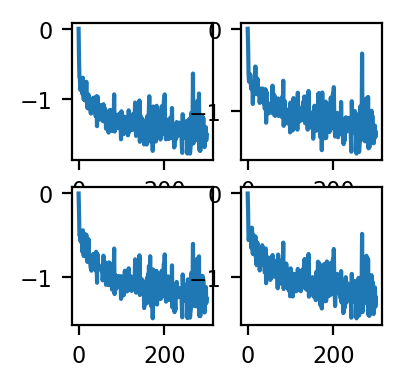

In [36]:
# plot desensitized images 
gammas = [0.01,0.1]
mode_num = 2
image_size = (28,28,1)
fig_height = len(gammas)
fig_width = mode_num
ind_list = [i for i in np.arange(0,1500,5)]
plt.close()
plt.figure(figsize=(fig_width,fig_height),dpi=200)

for ind_gamma,gamma in enumerate(gammas):
    for ind_mode in range(mode_num):
        plt_ind = ind_gamma * mode_num + ind_mode
        plt.subplot(fig_width,fig_height,plt_ind+1)
        log_dir = 'logs_mnist_mode_'+str(ind_mode)+'_gamma_'+str(gamma)
        loss_dir = log_dir+'/result_loss_12_19_9.npy'
        loss_results = np.load(loss_dir)
        d_loss = loss_results.item()['loss_u']
        d_loss = d_loss[slice(0,1500,5)]
        g_loss = loss_results.item()['loss_y']
        g_loss = g_loss[slice(0,1500,5)]
        plt.plot(range(len(d_loss)),d_loss)
#         plt.plot(range(len(g_loss)),g_loss)
plt.show()
#         plt.ylim([0,255])
#         plt.title(str(plt_ind))
#         plt.xticks([])
#         plt.yticks([])

In [26]:
test_list = [i for i in np.arange(0,1500,5)]

In [32]:
[0:1500:5]

SyntaxError: invalid syntax (<ipython-input-32-e83b8c5fc2c0>, line 1)